In [1]:
import os
import warnings
from pathlib import Path

import pandas as pd
import patsy
import numpy as np
import ot
import seaborn as sns
import time

import matplotlib.pyplot as plt
import sklearn.manifold as skmf
import sklearn.decomposition as skdc
import sklearn.metrics as skmr

import condo

from combat import combat

In [2]:
this_file = os.path.realpath('__file__')
data_path = os.path.join(Path(this_file).parent.parent, 'data')
pheno = pd.read_csv(os.path.join(data_path, 'pheno25.csv'), index_col=0)
expr = pd.read_csv(os.path.join(data_path, 'expr25.csv'), index_col=0)
exprTranspose = expr.T

In [3]:
# Combat
start_time = time.time()
mod = patsy.dmatrix("~ age + cancer", pheno, return_type="dataframe")
exprTranspose_combat = combat(exprTranspose, pheno['batch'], mod, "age")
expr_combat = exprTranspose_combat.T
duration_combat = time.time() - start_time
print(f"Combat time: {duration_combat}")

# Gaussian OT
start_time = time.time()
lder = condo.LinearAdapter(
    transform_type="location-scale",
)
lder.fit(
    expr[pheno.batch == 2].values, 
    expr[pheno.batch == 5].values,
)
expr_linear = lder.transform(expr.values)
duration_linear = time.time() - start_time
print(f"Gaussian OT time: {duration_linear}")
expr_linear[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

found 2 batches
found 1 numerical covariates...
	age
found 2 categorical variables:	cancer[T.Cancer], cancer[T.Normal]
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Combat time: 0.2193758487701416
Gaussian OT time: 10.199827194213867


In [17]:
# MMD
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mmder = condo.MMDAdapter(
        transform_type="location-scale",
        optim_kwargs={"epochs": 10, "alpha": 1e-3, "beta": 0.999},
        verbose=1,
    )
    mmder.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
    )
expr_mmd = mmder.transform(expr.values)
duration_mmd = time.time() - start_time
print(f"MMD time: {duration_mmd}")
expr_mmd[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

fix:0/22283
fix:223/22283
fix:446/22283
fix:669/22283
fix:892/22283
fix:1115/22283
fix:1338/22283
fix:1561/22283
fix:1784/22283
fix:2007/22283
fix:2230/22283
fix:2453/22283
fix:2676/22283
fix:2899/22283
fix:3122/22283
fix:3345/22283
fix:3568/22283
fix:3791/22283
fix:4014/22283
fix:4237/22283
fix:4460/22283
fix:4683/22283
fix:4906/22283
fix:5129/22283
fix:5352/22283
fix:5575/22283
fix:5798/22283
fix:6021/22283
fix:6244/22283
fix:6467/22283
fix:6690/22283
fix:6913/22283
fix:7136/22283
fix:7359/22283
fix:7582/22283
fix:7805/22283
fix:8028/22283
fix:8251/22283
fix:8474/22283
fix:8697/22283
fix:8920/22283
fix:9143/22283
fix:9366/22283
fix:9589/22283
fix:9812/22283
fix:10035/22283
fix:10258/22283
fix:10481/22283
fix:10704/22283
fix:10927/22283
fix:11150/22283
fix:11373/22283
fix:11596/22283
fix:11819/22283
fix:12042/22283
fix:12265/22283
fix:12488/22283
fix:12711/22283
fix:12934/22283
fix:13157/22283
fix:13380/22283
fix:13603/22283
fix:13826/22283
fix:14049/22283
fix:14272/22283
fix:14495/22

In [15]:
# Condo Linear ReverseKL
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_clinear = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="linear",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_clinear.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_clinear = cder_clinear.transform(expr.values)
duration_clinear = time.time() - start_time
print(f"ConDo Linear-ReverseKL time: {duration_clinear}")
expr_clinear[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_cgp = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="heteroscedastic-gp",
        divergence="reverse",
        debug=False,
        verbose=0,
    )
    cder_cgp.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_cgp = cder_cgp.transform(expr.values)
duration_cgp = time.time() - start_time
print(f"ConDo GP-ReverseKL time: {duration_cgp}")
expr_cgp[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

ConDo Linear-ReverseKL time: 207.94310879707336
fix:0/22283
fix:223/22283
fix:446/22283
fix:669/22283
fix:892/22283
fix:1115/22283
fix:1338/22283
fix:1561/22283
fix:1784/22283
fix:2007/22283
fix:2230/22283
fix:2453/22283
fix:2676/22283
fix:2899/22283
fix:3122/22283
fix:3345/22283
fix:3568/22283
fix:3791/22283
fix:4014/22283
fix:4237/22283
fix:4460/22283
fix:4683/22283
fix:4906/22283
fix:5129/22283
fix:5352/22283
fix:5575/22283
fix:5798/22283
fix:6021/22283
fix:6244/22283
fix:6467/22283
fix:6690/22283
fix:6913/22283
fix:7136/22283
fix:7359/22283
fix:7582/22283
fix:7805/22283
fix:8028/22283
fix:8251/22283
fix:8474/22283
fix:8697/22283
fix:8920/22283
fix:9143/22283
fix:9366/22283
fix:9589/22283
fix:9812/22283
fix:10035/22283
fix:10258/22283
fix:10481/22283
fix:10704/22283
fix:10927/22283
fix:11150/22283
fix:11373/22283
fix:11596/22283
fix:11819/22283
fix:12042/22283
fix:12265/22283
fix:12488/22283
fix:12711/22283
fix:12934/22283
fix:13157/22283
fix:13380/22283
fix:13603/22283
fix:13826/22

In [13]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cder_mmd = condo.ConDoAdapter(
        sampling="proportional",
        transform_type="location-scale",
        model_type="empirical",
        divergence="mmd",
        #optim_kwargs={"epochs": 1e-4, "alpha": 1e-3, "beta": 0.9},
        optim_kwargs={"epochs": 10, "alpha": 1e-4, "beta": 0.999},
        debug=False,
        verbose=1,
    )
    cder_mmd.fit(
        expr[pheno.batch == 2].values, 
        expr[pheno.batch == 5].values,
        pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str),
        pheno[pheno.batch==5].result.values.reshape(-1, 1).astype(str),
    )
expr_cmmd = cder_mmd.transform(expr.values)
duration_cmmd = time.time() - start_time
print(f"ConDo MMD: {duration_cmmd}")
expr_cmmd[np.where(pheno.batch == 5)[0],:] = expr.values[np.where(pheno.batch == 5)[0],:]

fix:0/22283
fix:223/22283
fix:446/22283
fix:669/22283
fix:892/22283
fix:1115/22283
fix:1338/22283
fix:1561/22283
fix:1784/22283
fix:2007/22283
fix:2230/22283
fix:2453/22283
fix:2676/22283
fix:2899/22283
fix:3122/22283
fix:3345/22283
fix:3568/22283
fix:3791/22283
fix:4014/22283
fix:4237/22283
fix:4460/22283
fix:4683/22283
fix:4906/22283
fix:5129/22283
fix:5352/22283
fix:5575/22283
fix:5798/22283
fix:6021/22283
fix:6244/22283
fix:6467/22283
fix:6690/22283
fix:6913/22283
fix:7136/22283
fix:7359/22283
fix:7582/22283
fix:7805/22283
fix:8028/22283
fix:8251/22283
fix:8474/22283
fix:8697/22283
fix:8920/22283
fix:9143/22283
fix:9366/22283
fix:9589/22283
fix:9812/22283
fix:10035/22283
fix:10258/22283
fix:10481/22283
fix:10704/22283
fix:10927/22283
fix:11150/22283
fix:11373/22283
fix:11596/22283
fix:11819/22283
fix:12042/22283
fix:12265/22283
fix:12488/22283
fix:12711/22283
fix:12934/22283
fix:13157/22283
fix:13380/22283
fix:13603/22283
fix:13826/22283
fix:14049/22283
fix:14272/22283
fix:14495/22

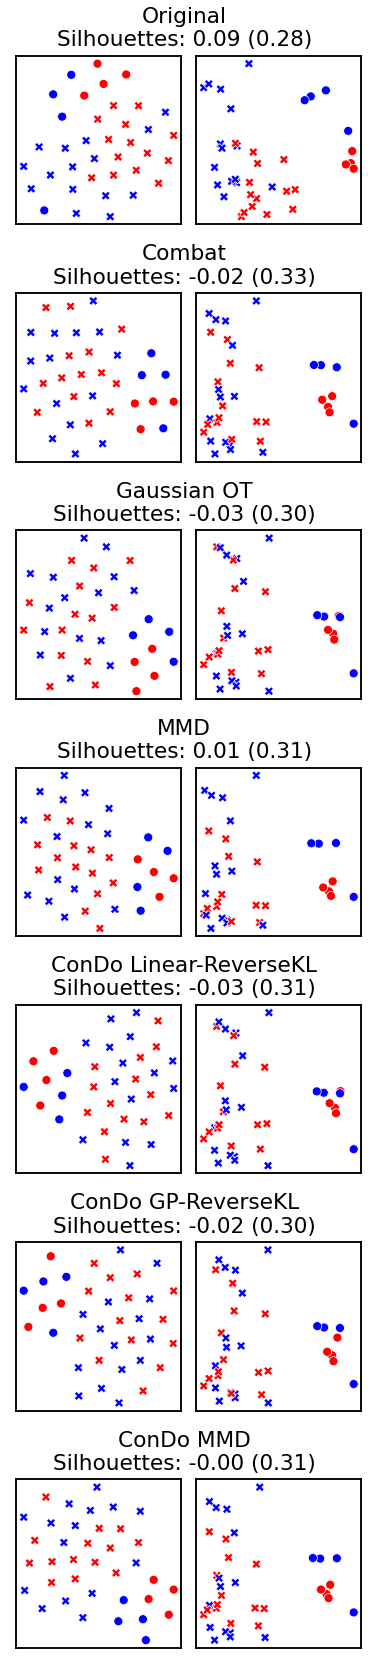

In [18]:
sns.set_context("talk")
dinfos = [
    (0, "Original", expr),
    (1, "Combat", expr_combat),
    (2, "Gaussian OT", expr_linear),
    (3, "MMD", expr_mmd),
    (4, "ConDo Linear-ReverseKL", expr_clinear),
    (5, "ConDo GP-ReverseKL", expr_cgp),
    (6, "ConDo MMD", expr_cmmd),
]
#fig, axes = plt.subplots(nrows=len(dinfos), ncols=2, figsize=(7, 10));
fig = plt.figure(figsize=(5, 23), constrained_layout=True)
subfigs = fig.subfigures(nrows=len(dinfos), ncols=1)

for dix, dname, dset in dinfos:
    axes = subfigs[dix].subplots(nrows=1, ncols=2)
    sil_result = skmr.silhouette_score(dset, pheno.result, metric='euclidean')
    sil_batch = skmr.silhouette_score(dset, pheno.batch, metric='euclidean')
    #subfigs[dix].suptitle(f"{dname}\nBatch:{sil_batch:.2f}   Result:{sil_result:.2f}");  
    subfigs[dix].suptitle(f"{dname}\nSilhouettes: {sil_batch:.2f} ({sil_result:.2f})");  

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsner = skmf.TSNE(n_components=2)
        tsne_embed = tsner.fit_transform(dset)
        tsne_data = pheno.copy()
        tsne_data["tsne 1"] = tsne_embed[:, 0]
        tsne_data["tsne 2"] = tsne_embed[:, 1]

    pcaer = skdc.PCA(n_components=2)
    pca_embed = pcaer.fit_transform(dset)
    pca_data = pheno.copy()
    pca_data["pc 1"] = pca_embed[:, 0]
    pca_data["pc 2"] = pca_embed[:, 1]           
    sns.scatterplot(
        data=tsne_data, ax=axes[0],
        x="tsne 1", y="tsne 2", hue="batch", style="result", 
        palette=["red", "blue"], legend=False,
    )
    if dix < 0:
        leg = "auto"
    else:
        leg = False
    sns.scatterplot(
        data=pca_data, ax=axes[1],
        x="pc 1", y="pc 2", hue="batch", style="result", 
        palette=["red", "blue"], legend=leg);
    """
    if dix == 0:
        plt.legend(
            loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=2,
        );
    """
    """
    #(_, max_x) = axes[1].get_xlim();
    #(_, max_x) = axes[1].get_xlim();

    axes[1].text(
        #np.max(pca_embed[:,0])*2.0, 0.5, 
        1.2, 0.5,
        f"Silhouette\nBatch:{sil_batch:.2f}\nOutcome:{sil_result:.2f}",
        transform = axes[1].transAxes); 
    """
    axes[0].set_xticks([]);
    axes[1].set_xticks([]);
    axes[0].set_yticks([]);
    axes[1].set_yticks([]);
    axes[1].set_yticks([]);
    axes[0].set_xlabel(None);
    axes[1].set_xlabel(None);
    axes[0].set_ylabel(None);
    axes[1].set_ylabel(None);
fig.savefig("figure-bladderbatch-noconfounding.pdf", bbox_inches="tight")

In [ ]:
#pd.concat([expr_combat.iloc[:, 0]-expr.iloc[:, 0], pheno], axis=1)

In [ ]:
pheno[pheno.batch==2].result.values.reshape(-1, 1).astype(str)

In [ ]:
import torch

In [ ]:
m = torch.rand(4)
A = torch.rand(3, 4)



In [ ]:
print(A @ torch.diag(m).T)
print(A * m.reshape(1, -1))

In [ ]:
np.diag(np.ones(4))

In [ ]:
import numpy as np
np.diag(1.0 / np.diag(2 * np.ones((4, 4))))

In [ ]:
cder_clinear.M_

In [ ]:
plt.hist(expr.values[:,0], 20);

In [ ]:
plt.figure();
plt.hist(expr.values[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr.values[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);
plt.figure();
plt.hist(expr_combat.values[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr_combat.values[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);
plt.figure();
plt.hist(expr_clinear[np.where(pheno.batch == 5)[0],0], 100, alpha=0.4);
plt.hist(expr_clinear[np.where(pheno.batch == 2)[0],0], 100, alpha=0.4);

In [ ]:
expr_clinear.shape

In [ ]:
print(skmr.silhouette_score(expr, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_combat, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_combat, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_linear, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_linear, pheno.batch, metric='euclidean')) # high is bad
print("ConDo Linear-ReverseKL")
print(skmr.silhouette_score(expr_clinear, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_clinear, pheno.batch, metric='euclidean')) # high is bad
print(skmr.silhouette_score(expr_cgp, pheno.result, metric='euclidean'))  # high is good
print(skmr.silhouette_score(expr_cgp, pheno.batch, metric='euclidean')) # high is bad

In [ ]:
pheno[pheno.batch == 2].shape

In [ ]:
pheno[pheno.batch == 5]

In [ ]:
pheno[pheno.batch == 2]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
cder = cder_cgp
plt.figure(figsize=(5,4), dpi=150)
color_vals = cder.debug_dict_["mb_objs"] + 1 - np.min(cder.debug_dict_["mb_objs"])
plt.pcolormesh(
    cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T,
    norm=LogNorm(vmin=color_vals.min(), vmax=color_vals.max())
);
plt.xscale('log');

cbar = plt.colorbar();
cbar.ax.get_yaxis().set_ticks([color_vals.min(), color_vals.max()]);
cbar.ax.get_yaxis().set_ticklabels(
    [int(np.round(cder.debug_dict_["mb_objs"].min())), int(np.round(cder.debug_dict_["mb_objs"].max()))]);
cont = plt.contour(
    cder.debug_dict_["m_plot"], cder.debug_dict_["b_plot"], color_vals.T, 
    levels=np.geomspace(color_vals.min(), color_vals.max(), 8), colors='white', linestyles='solid');
plt.ylabel('b');
plt.xlabel('m');
#plt.scatter(true_m, true_b, marker='s', c='orange');
plt.scatter(cder.M_[0,0], cder.b_[0], marker='x', c='red');
plt.tight_layout();